## Step 1: Imports and Setup

In [1]:
# ============================================================
# STEP 1: IMPORTS AND SETUP
# ============================================================
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from torch.utils.data import TensorDataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")

Using device: cpu
PyTorch version: 2.8.0+cu126


## Step 2: Load Data

In [2]:
# ============================================================
# STEP 2: LOAD DATA
# ============================================================
# Dataset: Google Stock Price from Kaggle
# Link: https://www.kaggle.com/datasets/medharawat/google-stock-price
# License: CC0 Public Domain

# Stock ticker name (for plot titles)
ticker = "GOOGL"

# Load training and test data from Kaggle
train_df = pd.read_csv('/kaggle/input/d/medharawat/google-stock-price/Google_Stock_Price_Train.csv', thousands=',')
test_df = pd.read_csv('/kaggle/input/d/medharawat/google-stock-price/Google_Stock_Price_Test.csv', thousands=',')

# Combine for full dataset (we'll do our own split later)
df = pd.concat([train_df, test_df], ignore_index=True)

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

# Clean numeric columns (remove commas and convert to float)
for col in ['Open', 'High', 'Low', 'Close']:
    if df[col].dtype == 'object':
        df[col] = df[col].str.replace(',', '').astype(float)

# Volume might have commas too
if df['Volume'].dtype == 'object':
    df['Volume'] = df['Volume'].str.replace(',', '').astype(int)

print(f"Dataset Shape: {df.shape}")
print(f"Date Range: {df.index[0]} to {df.index[-1]}")
print(f"\nFirst 5 rows:")
print(df.head())
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")
print(f"\nStatistical Summary:")
df.describe()

Dataset Shape: (1278, 5)
Date Range: 2012-01-03 00:00:00 to 2017-01-31 00:00:00

First 5 rows:
              Open    High     Low   Close    Volume
Date                                                
2012-01-03  325.25  332.83  324.97  663.59   7380500
2012-01-04  331.27  333.87  329.08  666.45   5749400
2012-01-05  329.83  330.75  326.89  657.21   6590300
2012-01-06  328.34  328.77  323.68  648.24   5405900
2012-01-09  322.04  322.29  309.46  620.76  11688800

Data Types:
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object

Missing Values:
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Statistical Summary:


,Open,High,Low,Close,Volume
count,1278.000000,1278.000000,1278.000000,1278.000000,1.278000e+03
mean,537.994906,542.168897,533.278803,714.160039,3.134661e+06
std,154.508365,155.582501,153.174011,163.892416,2.265015e+06
min,279.120000,281.210000,277.220000,491.200000,7.900000e+03
25%,406.037500,408.230000,403.335000,578.412500,1.608700e+06
50%,538.395000,542.330000,534.355000,698.150000,2.528700e+06
75%,668.862500,677.705000,662.190000,785.572500,4.106200e+06
max,837.810000,841.950000,827.010000,1216.830000,2.497790e+07


## Step 3: Exploratory Data Analysis

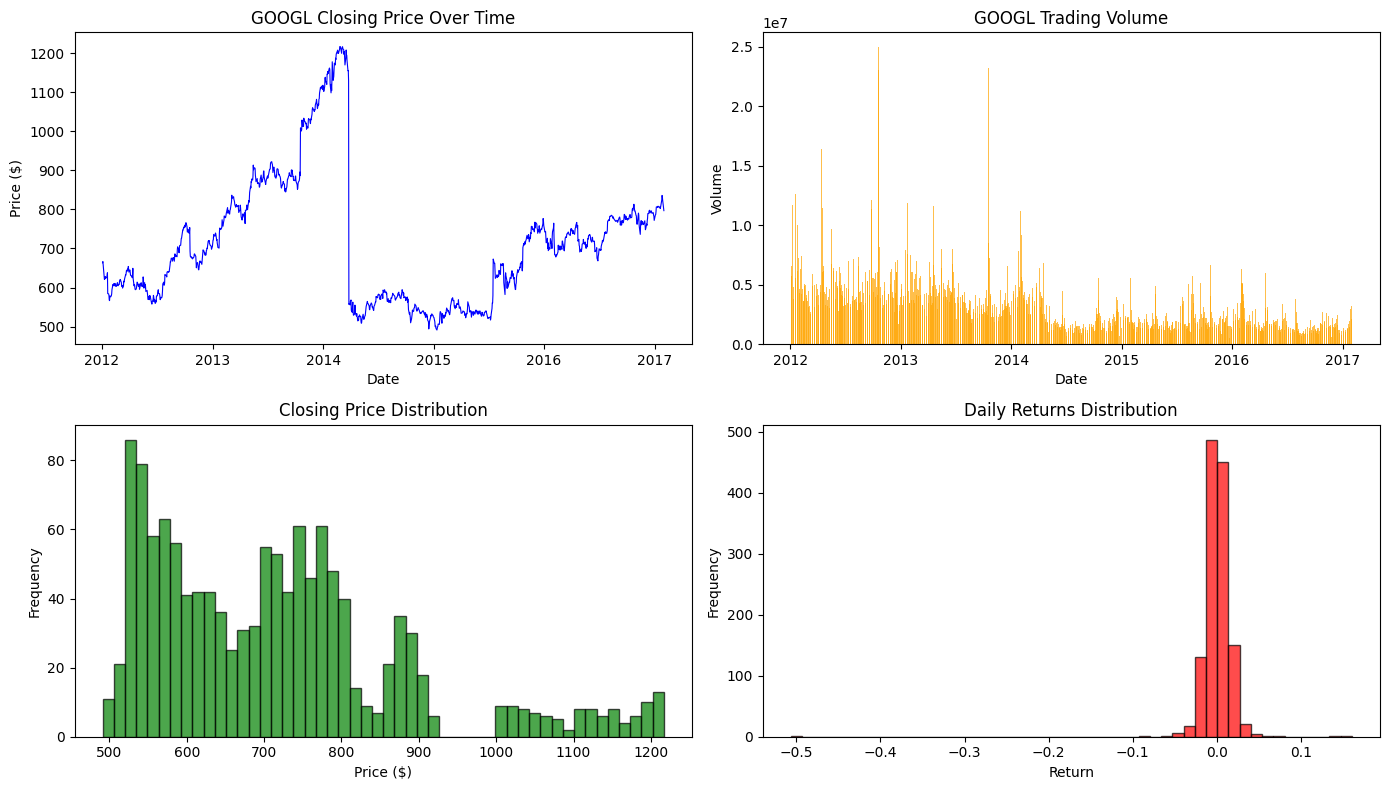

In [3]:
# ============================================================
# STEP 3: EXPLORATORY DATA ANALYSIS
# ============================================================
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Plot 1: Closing Price Over Time
axes[0, 0].plot(df.index, df['Close'], color='blue', linewidth=0.8)
axes[0, 0].set_title(f'{ticker} Closing Price Over Time')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Price ($)')

# Plot 2: Volume Over Time
axes[0, 1].bar(df.index, df['Volume'], color='orange', alpha=0.7, width=2)
axes[0, 1].set_title(f'{ticker} Trading Volume')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Volume')

# Plot 3: Price Distribution
axes[1, 0].hist(df['Close'], bins=50, color='green', edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Closing Price Distribution')
axes[1, 0].set_xlabel('Price ($)')
axes[1, 0].set_ylabel('Frequency')

# Plot 4: Daily Returns
df['Returns'] = df['Close'].pct_change()
axes[1, 1].hist(df['Returns'].dropna(), bins=50, color='red', edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Daily Returns Distribution')
axes[1, 1].set_xlabel('Return')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## Step 4: Data Preprocessing

In [4]:
# ============================================================
# STEP 4: DATA PREPROCESSING (RETURNS + Z-SCORE)
# ============================================================
# IMPROVEMENT 1: Predict RETURNS instead of prices
# Returns = (P_t - P_{t-1}) / P_{t-1}
# Returns are already small numbers centered around 0

from sklearn.preprocessing import StandardScaler

# Calculate returns for all price columns
df_returns = df.copy()

# Calculate returns: (today - yesterday) / yesterday
df_returns['Close_Return'] = df_returns['Close'].pct_change()
df_returns['Open_Return'] = df_returns['Open'].pct_change()
df_returns['High_Return'] = df_returns['High'].pct_change()
df_returns['Low_Return'] = df_returns['Low'].pct_change()

# Normalize volume (percentage of max)
df_returns['Volume_Norm'] = df_returns['Volume'] / df_returns['Volume'].max()

# Drop first row (NaN from pct_change)
df_returns = df_returns.dropna()

# Store original Close prices for later conversion back to prices
original_close_prices = df_returns['Close'].values

# Select features: returns (small numbers) + normalized volume
feature_columns = ['Open_Return', 'High_Return', 'Low_Return', 'Close_Return', 'Volume_Norm']
data = df_returns[feature_columns].values

print(f"Using {len(feature_columns)} features: {feature_columns}")
print(f"Data shape: {data.shape}")

# Show returns statistics (they're already small!)
print(f"\nReturns statistics (Close_Return):")
print(f"  Mean:  {df_returns['Close_Return'].mean():.6f}")
print(f"  Std:   {df_returns['Close_Return'].std():.6f}")
print(f"  Min:   {df_returns['Close_Return'].min():.6f}")
print(f"  Max:   {df_returns['Close_Return'].max():.6f}")

# IMPROVEMENT 2: Use StandardScaler (Z-score normalization)
# Z = (x - mean) / std
# Centers data at 0, most values in [-3, 3]
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Separate scaler for target (Close returns) for inverse transform
target_scaler = StandardScaler()
target_scaler.fit(df_returns[['Close_Return']].values)

print(f"\nAfter StandardScaler (Z-score):")
print(f"  Mean: {data_scaled.mean():.6f} (should be ~0)")
print(f"  Std:  {data_scaled.std():.6f} (should be ~1)")
print(f"  Range: [{data_scaled.min():.2f}, {data_scaled.max():.2f}]")

Using 5 features: ['Open_Return', 'High_Return', 'Low_Return', 'Close_Return', 'Volume_Norm']
Data shape: (1277, 5)

Returns statistics (Close_Return):
  Mean:  0.000405
  Std:   0.020383
  Min:   -0.506648
  Max:   0.160524

After StandardScaler (Z-score):
  Mean: 0.000000 (should be ~0)
  Std:  1.000000 (should be ~1)
  Range: [-24.89, 11.93]


In [5]:
# ============================================================
# CREATE SEQUENCES FOR LSTM (PREDICTING RETURNS)
# ============================================================

def create_sequences_multifeature(data, seq_length, target_col):
    """
    Create sequences for LSTM training.
    
    Args:
        data: Scaled data with multiple features
        seq_length: Number of past days to use
        target_col: Index of target column (Close_Return = index 3)
    
    Returns:
        X: Input sequences (samples, seq_length, num_features)
        y: Target values (next day's return)
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :])
        y.append(data[i + seq_length, target_col])
    return np.array(X), np.array(y)

# Hyperparameters
SEQUENCE_LENGTH = 20

# Close_Return is at index 3 in feature_columns
TARGET_COL = 3

X, y = create_sequences_multifeature(data_scaled, SEQUENCE_LENGTH, target_col=TARGET_COL)

# Also save the corresponding original prices for converting returns back to $
# We need the price BEFORE each prediction to calculate: Price_t = Price_{t-1} * (1 + return)
prices_for_conversion = original_close_prices[SEQUENCE_LENGTH - 1:-1]  # Price at end of each sequence

NUM_FEATURES = X.shape[2]

print(f"Sequence length: {SEQUENCE_LENGTH} days")
print(f"Number of features: {NUM_FEATURES}")
print(f"Predicting: RETURNS (not prices)")
print(f"\nSequence shape X: {X.shape}")
print(f"Target shape y: {y.shape}")
print(f"Conversion prices shape: {prices_for_conversion.shape}")

Sequence length: 20 days
Number of features: 5
Predicting: RETURNS (not prices)

Sequence shape X: (1257, 20, 5)
Target shape y: (1257,)
Conversion prices shape: (1257,)


## Step 5: Train / Validation / Test Split

In [6]:
# ============================================================
# STEP 5: TRAIN / VALIDATION / TEST SPLIT
# ============================================================

# Time-series split: must be chronological (no shuffling!)
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)
test_size = len(X) - train_size - val_size

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

# Also split the conversion prices
prices_train = prices_for_conversion[:train_size]
prices_val = prices_for_conversion[train_size:train_size + val_size]
prices_test = prices_for_conversion[train_size + val_size:]

print(f"Training set:   {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set:       {X_test.shape[0]} samples")

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_val_tensor = torch.FloatTensor(X_val).to(device)
y_val_tensor = torch.FloatTensor(y_val).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

# Create DataLoaders
BATCH_SIZE = 32

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)

val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nDataLoaders created with batch size: {BATCH_SIZE}")

Training set:   879 samples
Validation set: 188 samples
Test set:       190 samples

DataLoaders created with batch size: 32


## Step 6: LSTM Model Architecture

### LSTM Internal Structure
Each LSTM cell contains **4 parallel neural networks** (gates):

| Gate | Formula | Activation | Purpose |
|------|---------|------------|--------|
| **Forget** | $f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$ | Sigmoid | How much old memory to keep |
| **Input** | $i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)$ | Sigmoid | How much new info to add |
| **Candidate** | $\tilde{C}_t = \tanh(W_C \cdot [h_{t-1}, x_t] + b_C)$ | Tanh | What new info to add |
| **Output** | $o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)$ | Sigmoid | How much memory to expose |

**Cell State Update:** $C_t = f_t \odot C_{t-1} + i_t \odot \tilde{C}_t$

**Hidden State Update:** $h_t = o_t \odot \tanh(C_t)$

In [7]:
# ============================================================
# STEP 6: LSTM MODEL ARCHITECTURE (SIMPLIFIED)
# ============================================================
# Simple model to prevent overfitting on small dataset

class LSTMModel(nn.Module):
    """
    LSTM for Stock Price Prediction
    
    Architecture: Simple and regularized to prevent overfitting
    - Single LSTM layer
    - Dropout for regularization
    - Direct output (no complex FC layers)
    
    LSTM Gates (computed by PyTorch):
    - Forget Gate:    f_t = σ(W_f · [h_{t-1}, x_t] + b_f)
    - Input Gate:     i_t = σ(W_i · [h_{t-1}, x_t] + b_i)  
    - Candidate:      C̃_t = tanh(W_C · [h_{t-1}, x_t] + b_C)
    - Cell State:     C_t = f_t ⊙ C_{t-1} + i_t ⊙ C̃_t
    - Output Gate:    o_t = σ(W_o · [h_{t-1}, x_t] + b_o)
    - Hidden State:   h_t = o_t ⊙ tanh(C_t)
    """
    
    def __init__(self, input_size, hidden_size=64, num_layers=1, dropout=0.3):
        super(LSTMModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Single LSTM layer
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0  # No dropout between layers (only 1 layer)
        )
        
        # Simple output: hidden -> 1 prediction
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # Initialize hidden states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # LSTM forward pass
        lstm_out, _ = self.lstm(x, (h0, c0))
        
        # Take last time step output
        last_output = lstm_out[:, -1, :]
        
        # Dropout + Linear
        out = self.dropout(last_output)
        out = self.fc(out)
        
        return out

# Create model
model = LSTMModel(
    input_size=NUM_FEATURES,  # 5 features (OHLCV)
    hidden_size=64,
    num_layers=1,
    dropout=0.3
).to(device)

print(model)
print(f"\nTotal Parameters: {sum(p.numel() for p in model.parameters()):,}")

LSTMModel(
  (lstm): LSTM(5, 64, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Total Parameters: 18,241


## Step 7: Training Setup

In [8]:
# ============================================================
# STEP 7: TRAINING SETUP (HUBER LOSS)
# ============================================================

# IMPROVEMENT 3: Use Huber Loss instead of MSE
# Huber Loss = MSE for small errors, MAE for large errors
# Less sensitive to outliers, better gradients for small differences
criterion = nn.HuberLoss(delta=1.0)

# Optimizer: Adam with weight decay
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10
)

# Training parameters
NUM_EPOCHS = 150
EARLY_STOP_PATIENCE = 25

print("Training Configuration:")
print(f"  - Loss Function: HuberLoss (delta=1.0)")
print(f"  - Optimizer: Adam (lr=0.001, weight_decay=1e-5)")
print(f"  - Max Epochs: {NUM_EPOCHS}")
print(f"  - Early Stopping Patience: {EARLY_STOP_PATIENCE}")
print(f"\n📊 Huber Loss Advantage:")
print(f"  - For |error| < delta: behaves like MSE (smooth gradients)")
print(f"  - For |error| > delta: behaves like MAE (robust to outliers)")

Training Configuration:
  - Loss Function: HuberLoss (delta=1.0)
  - Optimizer: Adam (lr=0.001, weight_decay=1e-5)
  - Max Epochs: 150
  - Early Stopping Patience: 25

📊 Huber Loss Advantage:
  - For |error| < delta: behaves like MSE (smooth gradients)
  - For |error| > delta: behaves like MAE (robust to outliers)


## Step 8: Training Loop

In [9]:
# ============================================================
# STEP 8: TRAINING LOOP
# ============================================================

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                num_epochs, patience):
    """
    Training loop with validation and early stopping.
    """
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(num_epochs):
        # ================== TRAINING ==================
        model.train()
        train_loss = 0.0
        
        for X_batch, y_batch in train_loader:
            # Forward pass
            predictions = model(X_batch)
            loss = criterion(predictions.squeeze(), y_batch)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            
            # Gradient clipping (prevent exploding gradients)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # ================== VALIDATION ==================
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                predictions = model(X_batch)
                loss = criterion(predictions.squeeze(), y_batch)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        # Learning rate scheduler step
        scheduler.step(val_loss)
        
        # ================== EARLY STOPPING ==================
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
        
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] | "
                  f"Train Loss: {train_loss:.6f} | "
                  f"Val Loss: {val_loss:.6f} | "
                  f"LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        # Early stopping
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    return train_losses, val_losses

# Train the model!
print("Starting training...\n")
train_losses, val_losses = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler,
    NUM_EPOCHS, EARLY_STOP_PATIENCE
)
print("\nTraining complete!")

Starting training...

Epoch [10/150] | Train Loss: 0.225764 | Val Loss: 0.294243 | LR: 0.001000
Epoch [20/150] | Train Loss: 0.218486 | Val Loss: 0.305927 | LR: 0.000500
Epoch [30/150] | Train Loss: 0.218083 | Val Loss: 0.309687 | LR: 0.000250

Early stopping at epoch 30

Training complete!


## Step 9: Learning Curves Visualization

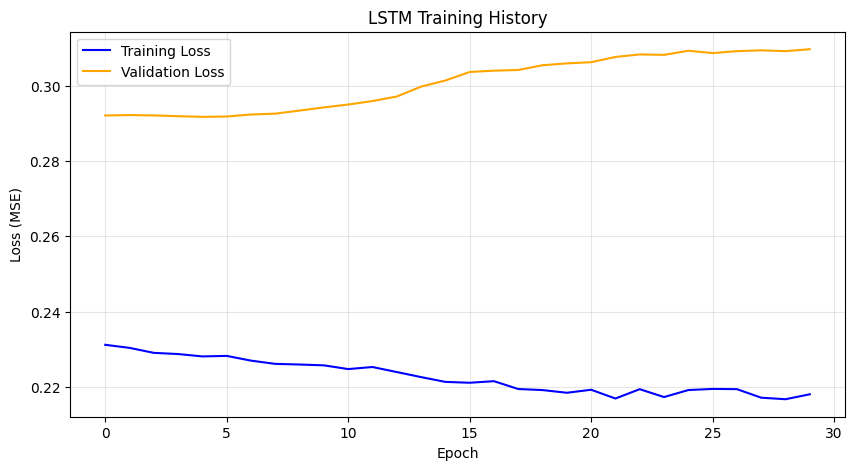

Final Training Loss: 0.218083
Final Validation Loss: 0.309687


In [10]:
# ============================================================
# STEP 9: LEARNING CURVES
# ============================================================

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.title('LSTM Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Final Training Loss: {train_losses[-1]:.6f}")
print(f"Final Validation Loss: {val_losses[-1]:.6f}")

## Step 10: Evaluation on Test Set

In [11]:
# ============================================================
# STEP 10: EVALUATION (RETURNS → PRICES CONVERSION)
# ============================================================

model.eval()

with torch.no_grad():
    # Get predictions (scaled returns)
    y_pred_scaled = model(X_test_tensor).cpu().numpy()
    y_test_scaled = y_test_tensor.cpu().numpy()

# Inverse transform to get actual returns
y_pred_returns = target_scaler.inverse_transform(y_pred_scaled)
y_actual_returns = target_scaler.inverse_transform(y_test_scaled.reshape(-1, 1))

# Convert RETURNS back to PRICES
# Formula: Price_t = Price_{t-1} * (1 + return_t)
y_pred_prices = prices_test.reshape(-1, 1) * (1 + y_pred_returns)
y_actual_prices = prices_test.reshape(-1, 1) * (1 + y_actual_returns)

# Calculate metrics in DOLLAR terms
mae = mean_absolute_error(y_actual_prices, y_pred_prices)
rmse = np.sqrt(mean_squared_error(y_actual_prices, y_pred_prices))
r2 = r2_score(y_actual_prices, y_pred_prices)

# Also calculate metrics on RETURNS (for comparison)
mae_returns = mean_absolute_error(y_actual_returns, y_pred_returns)
rmse_returns = np.sqrt(mean_squared_error(y_actual_returns, y_pred_returns))

print("=" * 50)
print("TEST SET EVALUATION METRICS")
print("=" * 50)
print(f"\n📈 Price Prediction Metrics:")
print(f"   MAE:   ${mae:.2f}")
print(f"   RMSE:  ${rmse:.2f}")
print(f"   R²:    {r2:.4f}")
print(f"\n📊 Returns Prediction Metrics:")
print(f"   MAE:   {mae_returns:.6f} ({mae_returns*100:.4f}%)")
print(f"   RMSE:  {rmse_returns:.6f} ({rmse_returns*100:.4f}%)")
print("=" * 50)

# For visualization later
y_pred = y_pred_prices
y_actual = y_actual_prices

TEST SET EVALUATION METRICS

📈 Price Prediction Metrics:
   MAE:   $5.85
   RMSE:  $7.86
   R²:    0.9536

📊 Returns Prediction Metrics:
   MAE:   0.007749 (0.7749%)
   RMSE:  0.010441 (1.0441%)


## Step 11: ARIMA Baseline Model

### What is ARIMA?

**ARIMA** (AutoRegressive Integrated Moving Average) is a classical statistical forecasting model that actually **learns patterns** from historical data.

| Component | Full Name | What It Does |
|-----------|-----------|--------------|
| **AR(p)** | AutoRegressive | Uses past p values to predict current value |
| **I(d)** | Integrated | Differences the data d times for stationarity |
| **MA(q)** | Moving Average | Uses past q forecast errors to improve prediction |

### ARIMA Formula

$$r_t = c + \phi_1 r_{t-1} + \phi_2 r_{t-2} + ... + \phi_p r_{t-p} + \theta_1 \epsilon_{t-1} + ... + \theta_q \epsilon_{t-q} + \epsilon_t$$

Where:
- $r_t$ = predicted return at time t
- $\phi$ = AR coefficients (learned from data)
- $\theta$ = MA coefficients (learned from data)
- $\epsilon$ = forecast errors

### Why ARIMA is a Fair Baseline

| Naive Baseline (return=0) | ARIMA Baseline |
|---------------------------|----------------|
| Assumes no patterns exist | Tries to find linear patterns |
| No learning involved | Learns from training data |
| Theoretical lower bound | Practical statistical benchmark |
| "Can we beat random?" | "Can we beat classical methods?" |

In [13]:
# ============================================================
# STEP 11: ARIMA BASELINE MODEL COMPARISON
# ============================================================
# ARIMA = AutoRegressive Integrated Moving Average
# A classical statistical model that ACTUALLY tries to forecast returns
# Unlike naive baseline (return=0), ARIMA learns patterns from past data

from statsmodels.tsa.arima.model import ARIMA

# Get the actual returns (unscaled) for ARIMA
# ARIMA works on the original returns, not z-scores
all_returns = df_returns['Close_Return'].values

# Split returns the same way as our LSTM data
# Account for sequence length offset
train_end = train_size + SEQUENCE_LENGTH
val_end = train_end + val_size

train_returns_arima = all_returns[:train_end]
test_returns_arima = all_returns[train_end + val_size:]

print("=" * 60)
print("ARIMA BASELINE MODEL")
print("=" * 60)
print(f"\n📊 What is ARIMA?")
print(f"   AR (AutoRegressive):  Use past returns to predict future")
print(f"   I  (Integrated):      Differencing for stationarity")
print(f"   MA (Moving Average):  Use past forecast errors")
print(f"\n   Formula: r_t = c + φ₁r_(t-1) + ... + φₚr_(t-p) + θ₁ε_(t-1) + ... + θ_qε_(t-q)")

# Fit ARIMA model on training data
# ARIMA(p,d,q) where:
#   p = number of AR terms (past values)
#   d = differencing order (0 since returns are already stationary)
#   q = number of MA terms (past errors)
print(f"\nFitting ARIMA(5,0,1) on training data...")

try:
    arima_model = ARIMA(train_returns_arima, order=(5, 0, 1))
    arima_fit = arima_model.fit()
    
    # Forecast for test period (one-step-ahead rolling forecast)
    arima_predictions = []
    history = list(train_returns_arima)
    
    for t in range(len(test_returns_arima)):
        model = ARIMA(history, order=(5, 0, 1))
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        arima_predictions.append(yhat)
        history.append(test_returns_arima[t])
        
        # Progress indicator
        if (t + 1) % 50 == 0:
            print(f"   Forecasted {t + 1}/{len(test_returns_arima)} steps...")
    
    arima_predictions = np.array(arima_predictions).reshape(-1, 1)
    
    # Convert ARIMA predictions (returns) to prices
    # Price_t = Price_{t-1} * (1 + return_t)
    arima_pred_prices = prices_test.reshape(-1, 1) * (1 + arima_predictions)
    
    # Calculate ARIMA metrics
    arima_mae = mean_absolute_error(y_actual_prices, arima_pred_prices)
    arima_rmse = np.sqrt(mean_squared_error(y_actual_prices, arima_pred_prices))
    arima_r2 = r2_score(y_actual_prices, arima_pred_prices)
    
    print(f"\n" + "=" * 60)
    print("ARIMA BASELINE RESULTS")
    print("=" * 60)
    print(f"ARIMA MAE:   ${arima_mae:.2f}")
    print(f"ARIMA RMSE:  ${arima_rmse:.2f}")
    print(f"ARIMA R²:    {arima_r2:.4f}")
    print("=" * 60)
    
    # Compare LSTM vs ARIMA
    lstm_vs_arima_mae = ((arima_mae - mae) / arima_mae) * 100
    lstm_vs_arima_rmse = ((arima_rmse - rmse) / arima_rmse) * 100
    
    print(f"\n📊 LSTM vs ARIMA Comparison:")
    print(f"   LSTM MAE:    ${mae:.2f}")
    print(f"   ARIMA MAE:   ${arima_mae:.2f}")
    print(f"   Improvement: {lstm_vs_arima_mae:.1f}%")
    
    if lstm_vs_arima_mae > 0:
        print(f"\n✅ LSTM outperforms ARIMA baseline!")
    elif lstm_vs_arima_mae > -5:
        print(f"\n⚖️ LSTM performs similarly to ARIMA (within 5%)")
    else:
        print(f"\n⚠️ ARIMA outperforms LSTM")
    
    # Store for visualization
    y_arima_pred = arima_pred_prices
    
except Exception as e:
    print(f"\n⚠️ ARIMA fitting failed: {e}")
    print("This can happen with small datasets or numerical issues.")
    y_arima_pred = None

ARIMA BASELINE MODEL

📊 What is ARIMA?
   AR (AutoRegressive):  Use past returns to predict future
   I  (Integrated):      Differencing for stationarity
   MA (Moving Average):  Use past forecast errors

   Formula: r_t = c + φ₁r_(t-1) + ... + φₚr_(t-p) + θ₁ε_(t-1) + ... + θ_qε_(t-q)

Fitting ARIMA(5,0,1) on training data...


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


   Forecasted 50/190 steps...


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

   Forecasted 100/190 steps...


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


   Forecasted 150/190 steps...


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



ARIMA BASELINE RESULTS
ARIMA MAE:   $5.70
ARIMA RMSE:  $7.70
ARIMA R²:    0.9554

📊 LSTM vs ARIMA Comparison:
   LSTM MAE:    $5.85
   ARIMA MAE:   $5.70
   Improvement: -2.6%

⚖️ LSTM performs similarly to ARIMA (within 5%)


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Step 12: Prediction Visualization

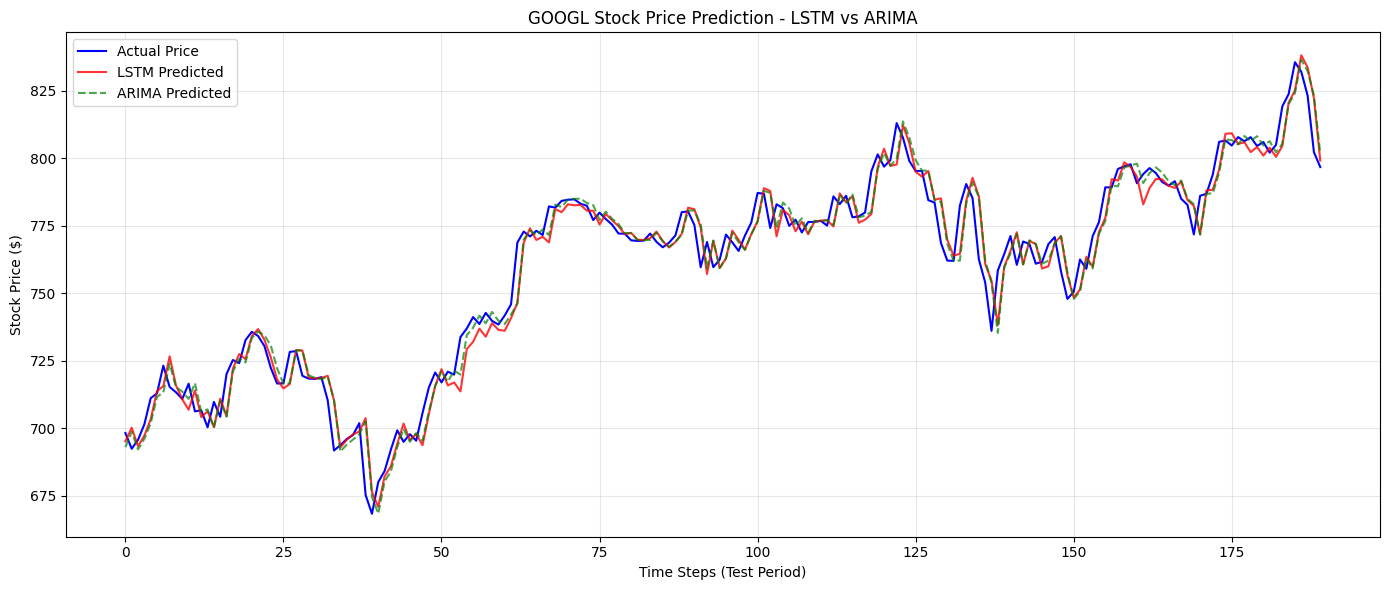


FINAL MODEL COMPARISON
Model                MAE ($)      RMSE ($)     R²        
------------------------------------------------------------
LSTM                 5.85         7.86         0.9536    
ARIMA (baseline)     5.70         7.70         0.9554    


In [15]:
# ============================================================
# STEP 12: PREDICTION VISUALIZATION (LSTM vs ARIMA)
# ============================================================

plt.figure(figsize=(14, 6))

# Plot actual vs predicted
plt.plot(y_actual, label='Actual Price', color='blue', linewidth=1.5)
plt.plot(y_pred, label='LSTM Predicted', color='red', linewidth=1.5, alpha=0.8)

# Add ARIMA predictions if available
if y_arima_pred is not None:
    plt.plot(y_arima_pred, label='ARIMA Predicted', color='green', linewidth=1.5, alpha=0.7, linestyle='--')

plt.title(f'{ticker} Stock Price Prediction - LSTM vs ARIMA')
plt.xlabel('Time Steps (Test Period)')
plt.ylabel('Stock Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary comparison
print("\n" + "=" * 60)
print("FINAL MODEL COMPARISON")
print("=" * 60)
print(f"{'Model':<20} {'MAE ($)':<12} {'RMSE ($)':<12} {'R²':<10}")
print("-" * 60)
print(f"{'LSTM':<20} {mae:<12.2f} {rmse:<12.2f} {r2:<10.4f}")
if y_arima_pred is not None:
    print(f"{'ARIMA (baseline)':<20} {arima_mae:<12.2f} {arima_rmse:<12.2f} {arima_r2:<10.4f}")
print("=" * 60)

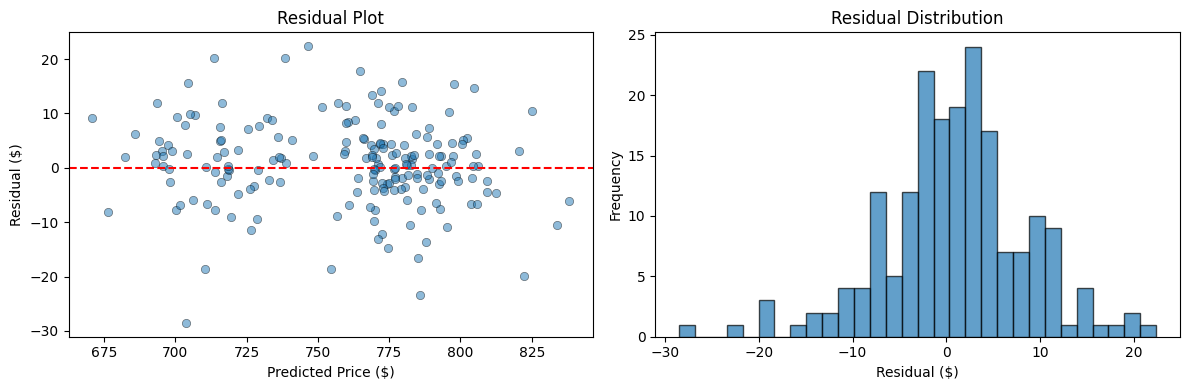

Mean Residual: $0.79
Std Residual:  $7.82


In [16]:
# ============================================================
# RESIDUAL ANALYSIS
# ============================================================

residuals = y_actual.flatten() - y_pred.flatten()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Residual Plot
axes[0].scatter(y_pred.flatten(), residuals, alpha=0.5, edgecolors='k', linewidths=0.5)
axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_xlabel('Predicted Price ($)')
axes[0].set_ylabel('Residual ($)')
axes[0].set_title('Residual Plot')

# Residual Distribution
axes[1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Residual ($)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Residual Distribution')

plt.tight_layout()
plt.show()

print(f"Mean Residual: ${residuals.mean():.2f}")
print(f"Std Residual:  ${residuals.std():.2f}")

## Summary

### Key Improvements Made
| Aspect | Original | Improved |
|--------|----------|----------|
| **Target** | Raw prices ($) | Returns (%) |
| **Scaling** | MinMax [0,1] | StandardScaler (Z-score) |
| **Loss Function** | MSE | Huber Loss |
| **Sequence Length** | 60 days | 20 days |

### Why These Changes Help

1. **Predicting Returns instead of Prices**
   - Returns are stationary (mean ~0, bounded variance)
   - Prices are non-stationary (trending, unbounded)
   - Returns are already small numbers - no extreme compression

2. **StandardScaler (Z-score)**
   - Centers data at mean=0, std=1
   - Better for LSTM's tanh activations (range [-1,1])
   - Handles outliers better than MinMax

3. **Huber Loss**
   - Smooth gradients for small errors (like MSE)
   - Robust to outliers (like MAE)
   - Better training stability

### Limitations
- Stock returns are still largely unpredictable (Efficient Market Hypothesis)
- Historical patterns may not repeat in the future
- External factors (news, events) not captured in price data